In [1]:
import torch

import spacy
import torch.nn as nn
import numpy as np
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Load the dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")
# Vocab dictionary
word_index = {}
# Model parameters
embedding_dim = 300
hidden_dim = 128

In [4]:
eng = spacy.load("en_core_web_sm")
stopwords = spacy.lang.en.stop_words.STOP_WORDS

/user/HS225/os00315/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/user/HS225/os00315/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [5]:
def remove_stop_words(dataset):       
    new_tokens, new_pos_tags, new_ner_tags = [], [], []
    
    for tokens, pos_tags, ner_tags in zip(dataset['tokens'], dataset['pos_tags'], dataset['ner_tags']):
        temp_tokens, temp_pos, temp_ner = [], [], []

        # To remove empty stings and corresponding ner_tags and pos_tags
        for i in range(len(tokens)):
            if (tokens[i] not in stopwords) or (ner_tags[i] != "B-O"):
                temp_tokens.append(tokens[i])
                temp_pos.append(pos_tags[i])
                temp_ner.append(ner_tags[i])
        if temp_tokens:
            new_tokens.append(temp_tokens)
            new_pos_tags.append(temp_pos)
            new_ner_tags.append(temp_ner)

    return {'tokens': new_tokens, 'pos_tags': new_pos_tags, 'ner_tags': new_ner_tags}

In [6]:
dataset['train'] = dataset['train'].map(remove_stop_words, batched=True)
dataset['validation'] = dataset['validation'].map(remove_stop_words, batched=True)
dataset['test'] = dataset['test'].map(remove_stop_words, batched=True)

In [7]:
label_encoding = {"B-O": 0, "B-AC": 1, "B-LF": 2, "I-LF": 3}

In [8]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [9]:
def encode_label(tags):
    global label_encoding
    return [label_encoding[tag] for tag in tags]

def build_vocab(dataset):
    global  word_index
    for item in dataset['tokens']:
        for word in item:
            if word not in word_index:
                word_index[word] = len(word_index)
    return word_index

In [10]:
word_index = build_vocab(train_dataset)
word_index = build_vocab(val_dataset)
word_index = build_vocab(test_dataset)

## Define the LSTM model

In [11]:
# LSTM model
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tags):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_dim, tags)

    def forward(self, sentence):
        embeds = self.embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        lstm_out = self.fc(lstm_out)
        return torch.log_softmax(lstm_out, dim=-1)

In [12]:
# Encode strings and return tensor
def encode_sequence(seq, encoder=None):
    if type(seq[0]) == int:
        encoded_ids = seq
    else:
        encoded_ids = [encoder[word] for word in seq]
    return torch.tensor(encoded_ids, dtype=torch.long)

In [13]:
# Evaluate the model
def evaluate(model, token_dataset, word_index):
    global label_encoding
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for i, datapoint in enumerate(token_dataset):
            inputs = encode_sequence(datapoint['tokens'], word_index)
            targets = encode_sequence(encode_label(datapoint['ner_tags']))
            tag_scores = model(inputs.unsqueeze(0))
            
            predicted_tags = tag_scores.max(-1)[1].squeeze().tolist()
            y_pred.extend(predicted_tags)
            y_true.extend(targets.tolist())    

    # Detailed performance metrics
    labels_indices = list(label_encoding.values())
    labels_names = list(label_encoding.keys())
    print(classification_report(y_true, y_pred, labels=labels_indices, target_names=labels_names))

    overall_f1 = f1_score(y_true, y_pred, average= 'macro')
    overall_precision = precision_score(y_true, y_pred, average='macro')
    overall_recall = recall_score(y_true, y_pred, average='macro')
    print(f'Overall F1 Score: {overall_f1}')
    print(f'Overall Precision Score: {overall_precision}')
    print(f'Overall Recall Score: {overall_recall}')

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[labels_indices])
    disp = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_names, yticklabels=labels_names) # adjust cmap if needed
    disp.set_xlabel("Predicted Label")
    disp.set_ylabel("True Label")
    disp.set_title("Confusion Matrix for NER-tags")
    plt.show()

## Training the model

              precision    recall  f1-score   support

         B-O       0.91      0.96      0.93      3165
        B-AC       0.74      0.47      0.58       270
        B-LF       0.50      0.35      0.41       150
        I-LF       0.64      0.61      0.63       288

    accuracy                           0.87      3873
   macro avg       0.70      0.60      0.64      3873
weighted avg       0.86      0.87      0.87      3873

Overall F1 Score: 0.6370552399792629
Overall Precision Score: 0.6958827218889801
Overall Recall Score: 0.5987291556959804


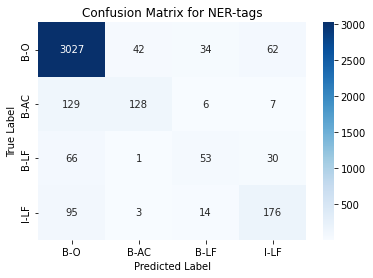

In [14]:
# Training the model
model = LSTM(embedding_dim, hidden_dim, len(word_index), 4)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.9)

for epoch in range(6):
    for i, datapoint in enumerate(train_dataset):
        model.zero_grad()
        sentence_in = encode_sequence(datapoint['tokens'], word_index)
        targets = encode_sequence(encode_label(datapoint['ner_tags']))
        tag_scores = model(sentence_in.unsqueeze(0))
        loss = loss_function(tag_scores.squeeze(0), targets)
        loss.backward()
        optimizer.step()
        # if i == 199:break
    
    # Model Validation
    model.eval()
    with torch.no_grad():
        for val_datapoint in val_dataset:
            val_inputs = encode_sequence(val_datapoint['tokens'], word_index)
            val_targets = encode_sequence(encode_label(val_datapoint['ner_tags']))
            val_tag_scores = model(val_inputs.unsqueeze(0))
            val_loss = loss_function(val_tag_scores.squeeze(0), val_targets)
            
    model.train()
    
# Evaluate on the test set
evaluate(model, test_dataset, word_index)